In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block -- MOST IMPORTANT TO CHECK VLAUES

In [2]:
evaluate_last_X_years = True
X=7
currency_pair = 'CAD=X'
numbers_in_currency = 'CAD'
share_name = 'EMA.TO'

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares
0,2016-12-31,1513,-35,1478,71,404,972,472,2511,6213,...,29221,1242,961,476,3724,14276,22517,186,-487,171
1,2017-03-31,1857,-21,1836,322,255,996,442,2308,6165,...,28946,970,1007,473,3249,14273,22016,166,-305,213
2,2017-06-30,1469,-10,1459,110,217,923,469,2159,6005,...,28584,963,1039,1175,3805,13446,21744,315,-418,213
3,2017-09-30,1427,-6,1421,99,221,896,452,2028,5775,...,27882,1070,939,1105,3980,13059,21340,560,-361,213
4,2017-12-31,1473,-2,1471,85,438,1071,418,2526,5805,...,28806,1161,1241,741,3946,13140,21694,152,-445,213


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
24,2022-12-31,2023-02-11,270,2358,0,2358,499,310,1503,769,...,0,39742,2025,2726,574,7287,15744,28315,-42,-892
25,2023-03-31,2023-04-21,271,2433,0,2433,576,280,1156,735,...,0,38817,1304,2833,682,5908,15807,26940,453,-637
26,2023-06-30,2023-07-21,273,1418,0,1418,44,313,1032,826,...,0,38472,1283,2852,96,5267,16441,26887,498,-714
27,2023-09-30,2023-10-21,274,1740,0,1740,118,254,1111,840,...,0,39147,1424,2666,676,5873,16243,27377,867,-712
28,2023-12-31,2024-02-11,284,1972,0,1972,240,567,1817,790,...,0,39480,1454,1433,676,4544,17689,27392,423,-874


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
24,2022-12-31,2023-02-11,270,2358,0,2358,499,310,1503,769,...,39742,2025,2726,574,7287,15744,28315,-42,-892,1.357405
25,2023-03-31,2023-04-21,271,2433,0,2433,576,280,1156,735,...,38817,1304,2833,682,5908,15807,26940,453,-637,1.352063
26,2023-06-30,2023-07-21,273,1418,0,1418,44,313,1032,826,...,38472,1283,2852,96,5267,16441,26887,498,-714,1.343352
27,2023-09-30,2023-10-21,274,1740,0,1740,118,254,1111,840,...,39147,1424,2666,676,5873,16243,27377,867,-712,1.341033
28,2023-12-31,2024-02-11,284,1972,0,1972,240,567,1817,790,...,39480,1454,1433,676,4544,17689,27392,423,-874,1.361617


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
24,2022-12-31,2023-02-11,270,2358,0,2358,499,310,1503,769,...,39742,2025,2726,574,7287,15744,28315,-42,-892,1.357405
25,2023-03-31,2023-04-21,271,2433,0,2433,576,280,1156,735,...,38817,1304,2833,682,5908,15807,26940,453,-637,1.352063
26,2023-06-30,2023-07-21,273,1418,0,1418,44,313,1032,826,...,38472,1283,2852,96,5267,16441,26887,498,-714,1.343352
27,2023-09-30,2023-10-21,274,1740,0,1740,118,254,1111,840,...,39147,1424,2666,676,5873,16243,27377,867,-712,1.341033
28,2023-12-31,2024-02-11,284,1972,0,1972,240,567,1817,790,...,39480,1454,1433,676,4544,17689,27392,423,-874,1.361617


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2017-02-13,32.302971,2016-12-31,1513.0,1.660819,39.204678,171.0,2692.0,15.74269,404.0,...,0.229424,0.770576,6.226337,0.112721,14.980198,0.29661,0.976867,0.046927,0.009719,0.042363
1,2017-02-20,32.274426,2016-12-31,1513.0,1.660819,39.204678,171.0,2692.0,15.74269,404.0,...,0.229424,0.770576,6.226337,0.112721,14.980198,0.29661,0.976867,0.046927,0.009719,0.042363
2,2017-02-27,32.410007,2016-12-31,1513.0,1.660819,39.204678,171.0,2692.0,15.74269,404.0,...,0.229424,0.770576,6.226337,0.112721,14.980198,0.29661,0.976867,0.046927,0.009719,0.042363
3,2017-03-06,32.459949,2016-12-31,1513.0,1.660819,39.204678,171.0,2692.0,15.74269,404.0,...,0.229424,0.770576,6.226337,0.112721,14.980198,0.29661,0.976867,0.046927,0.009719,0.042363
4,2017-03-13,32.923779,2016-12-31,1513.0,1.660819,39.204678,171.0,2692.0,15.74269,404.0,...,0.229424,0.770576,6.226337,0.112721,14.980198,0.29661,0.976867,0.046927,0.009719,0.042363


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2017-02-13,32.302971,2016-12-31,1513.0,1.660819,39.204678,171.0,2692.0,15.74269,404.0,...,0.29661,0.976867,0.046927,0.009719,0.042363,19.450028,0.823957,0.912724,4.566558,2.051935
1,2017-02-20,32.274426,2016-12-31,1513.0,1.660819,39.204678,171.0,2692.0,15.74269,404.0,...,0.29661,0.976867,0.046927,0.009719,0.042363,19.432841,0.823229,0.911918,4.565751,2.050121
2,2017-02-27,32.410007,2016-12-31,1513.0,1.660819,39.204678,171.0,2692.0,15.74269,404.0,...,0.29661,0.976867,0.046927,0.009719,0.042363,19.514476,0.826687,0.915749,4.569582,2.058734
3,2017-03-06,32.459949,2016-12-31,1513.0,1.660819,39.204678,171.0,2692.0,15.74269,404.0,...,0.29661,0.976867,0.046927,0.009719,0.042363,19.544547,0.827961,0.917160,4.570993,2.061906
4,2017-03-13,32.923779,2016-12-31,1513.0,1.660819,39.204678,171.0,2692.0,15.74269,404.0,...,0.29661,0.976867,0.046927,0.009719,0.042363,19.823824,0.839792,0.930265,4.584099,2.091369


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

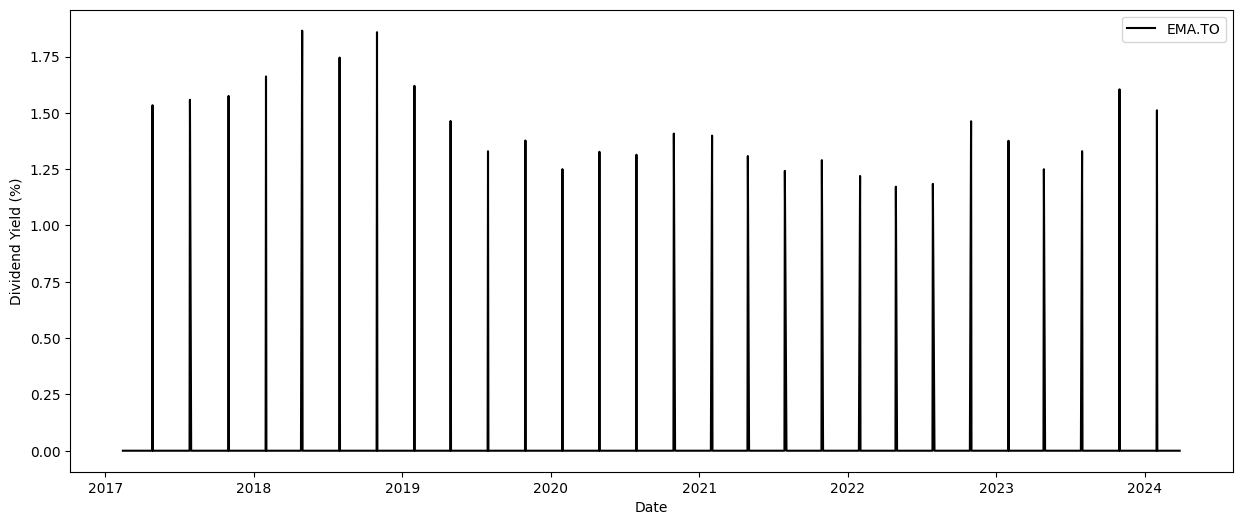

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate    0.008066
share_price      1.000000
Name: share_price, dtype: float64


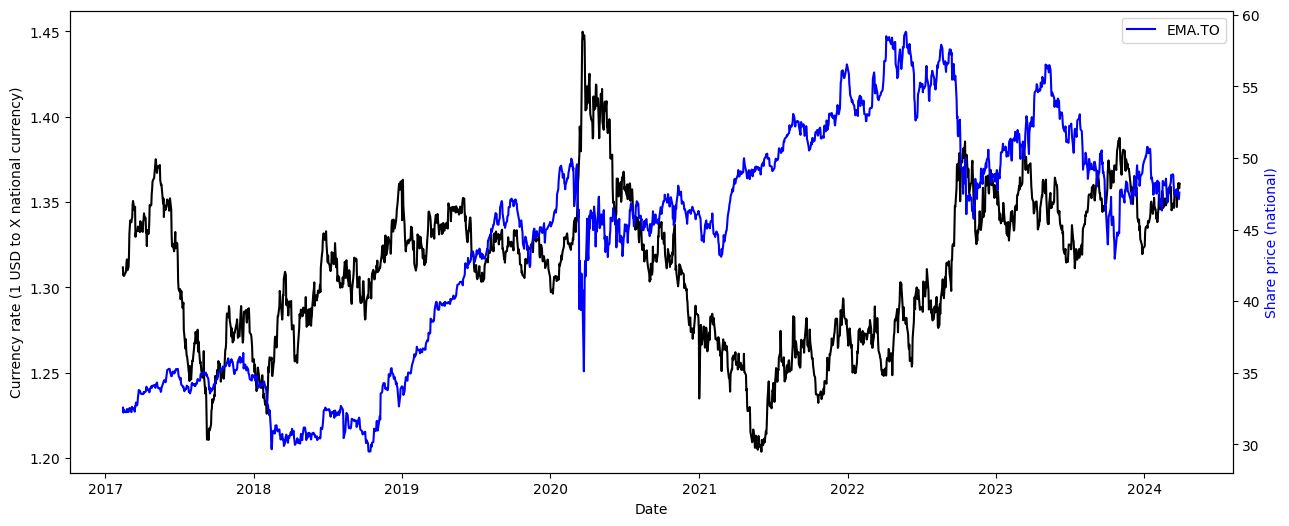

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

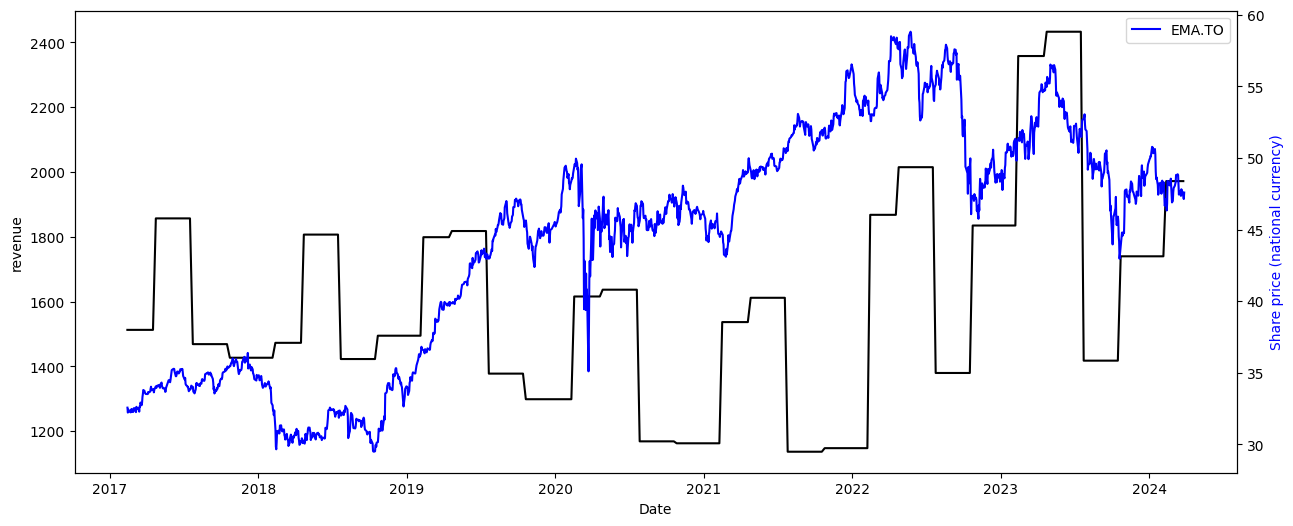

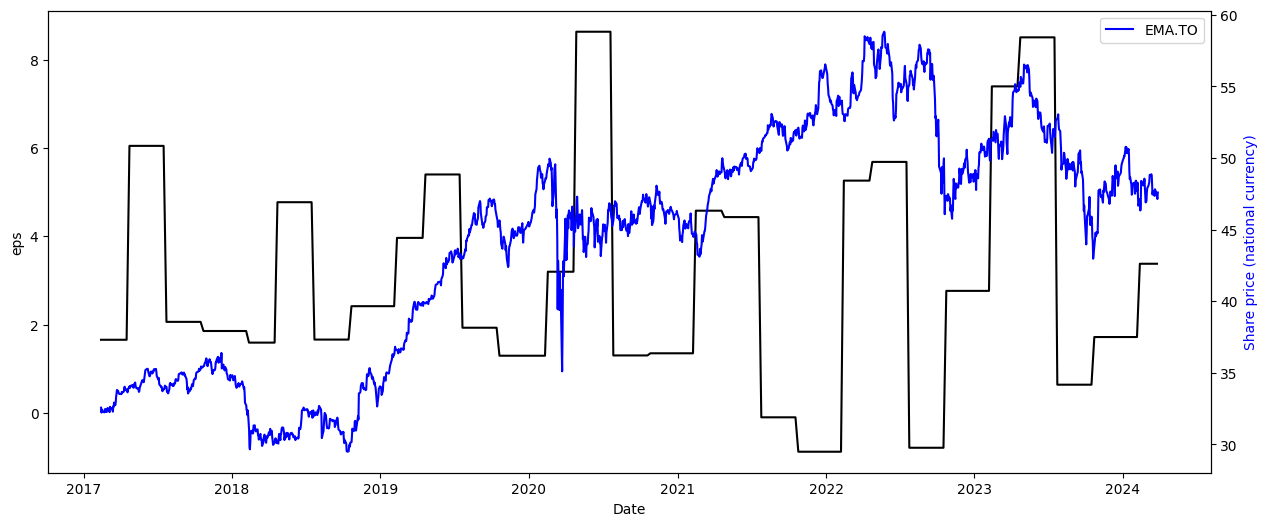

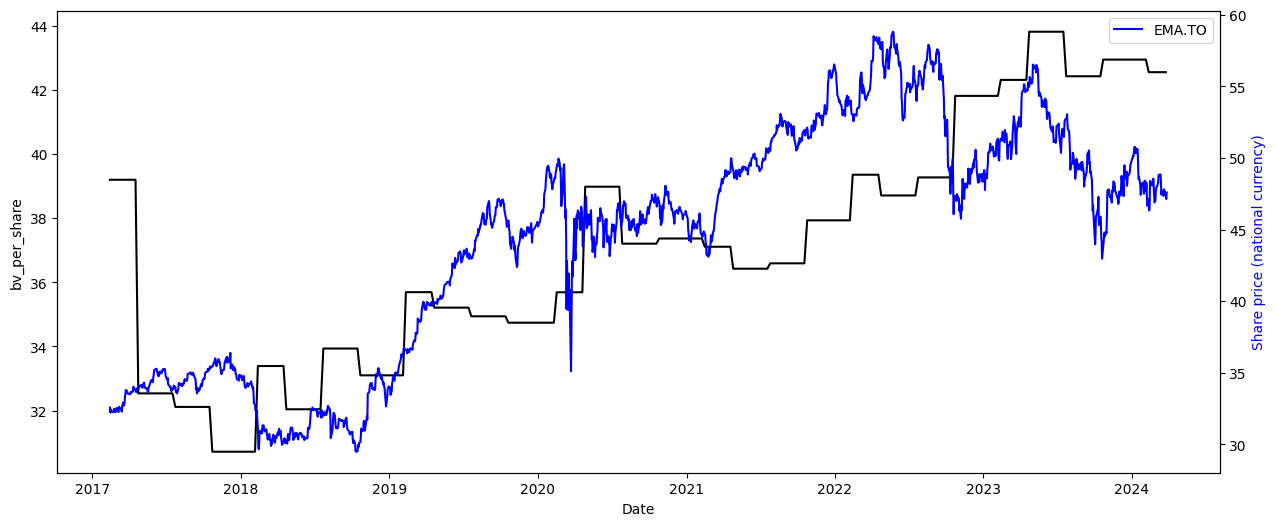

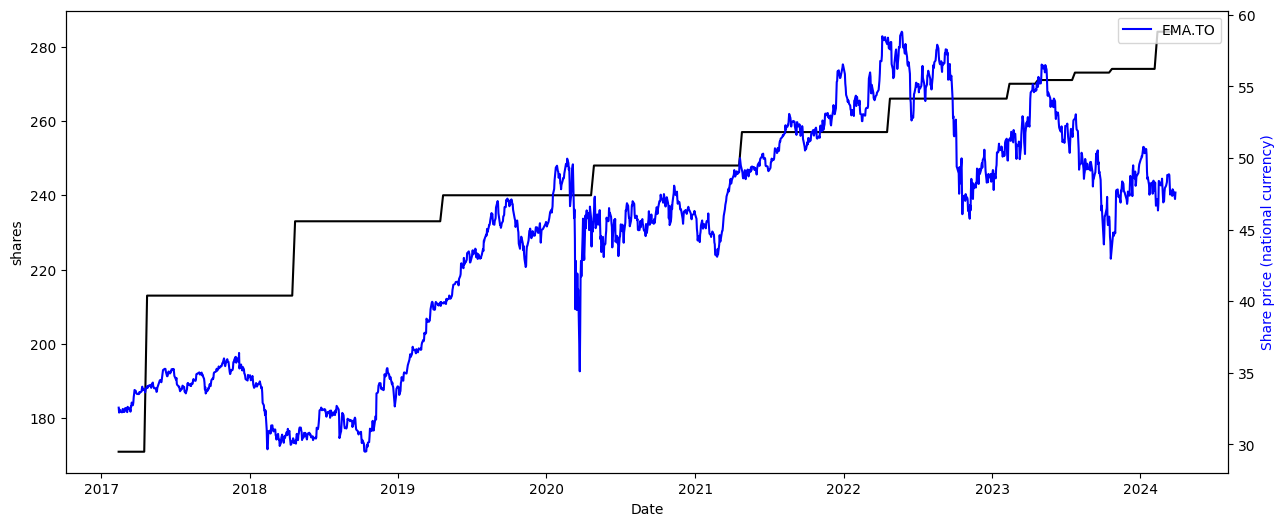

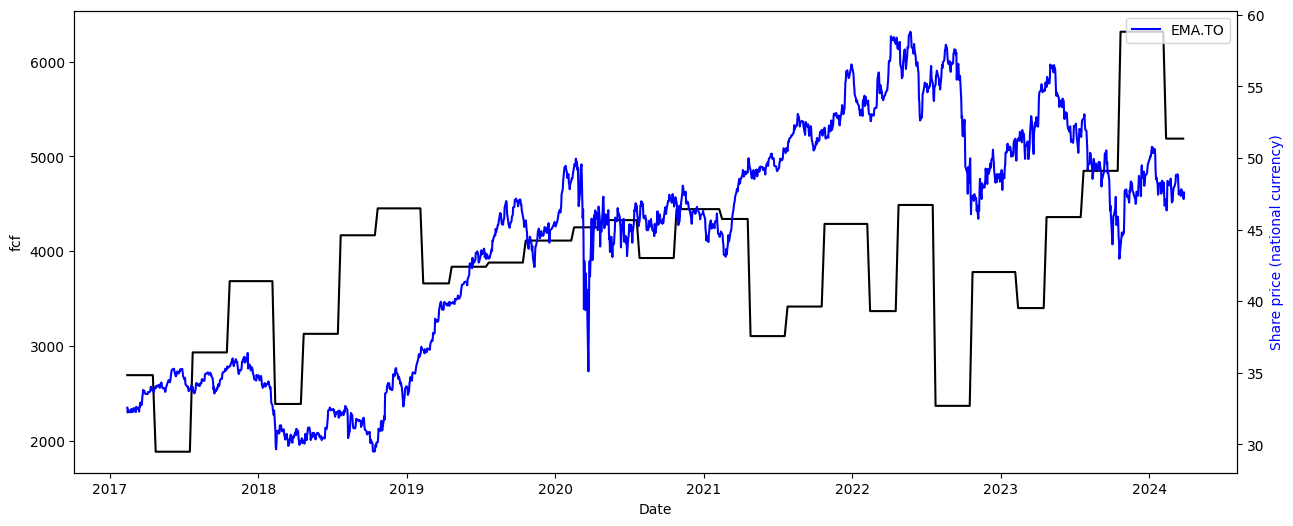

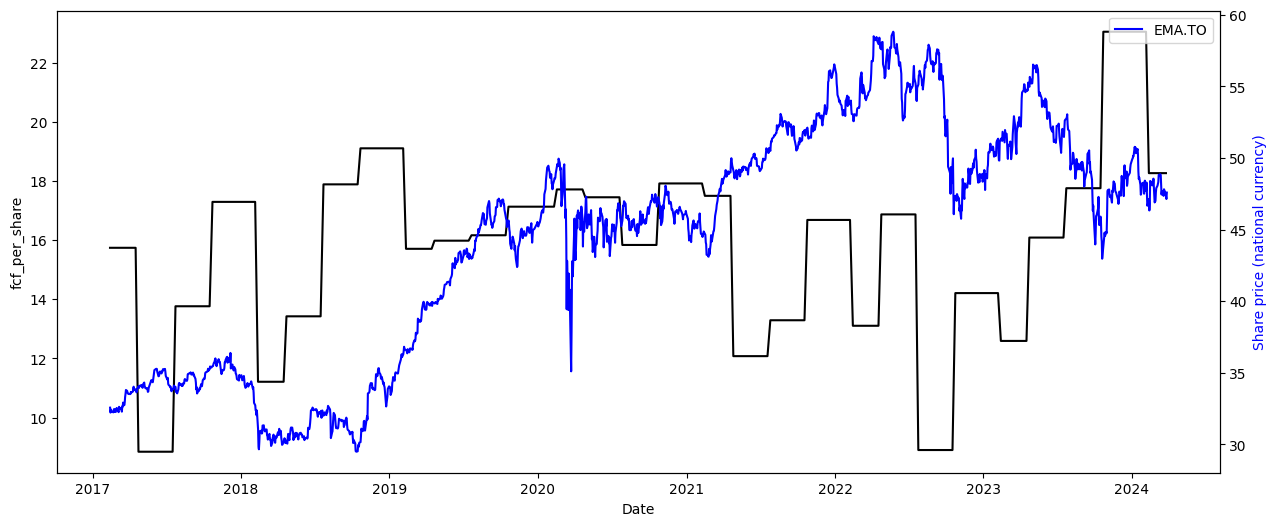

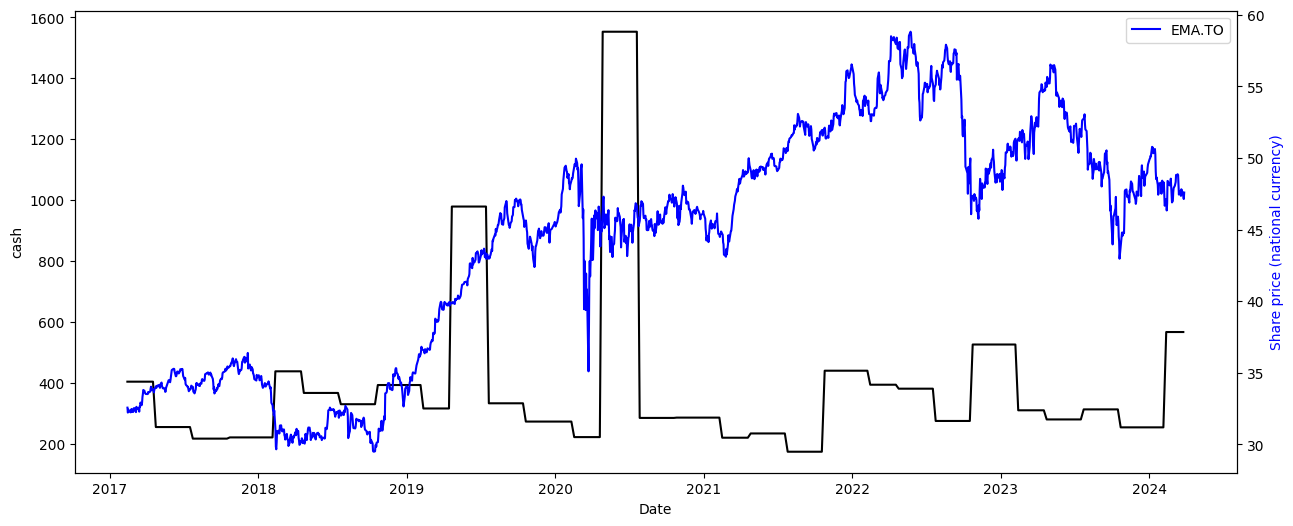

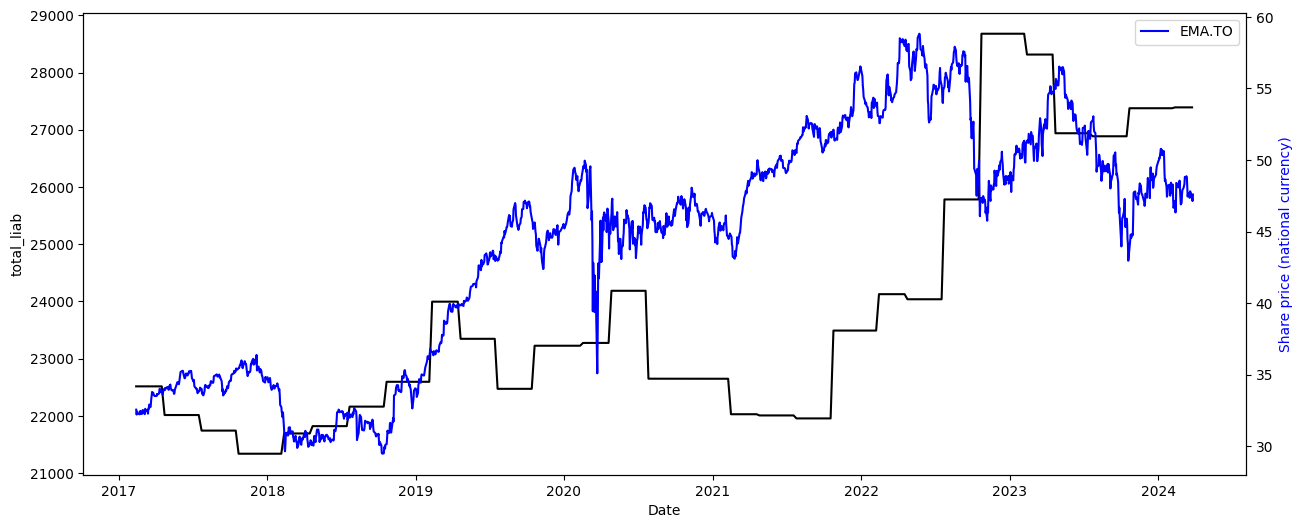

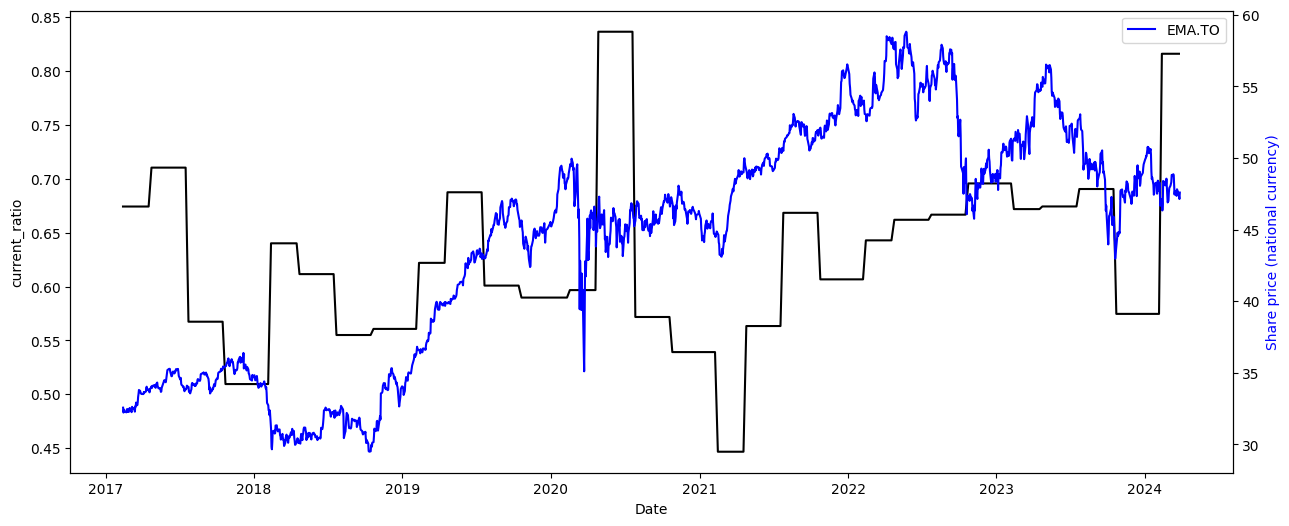

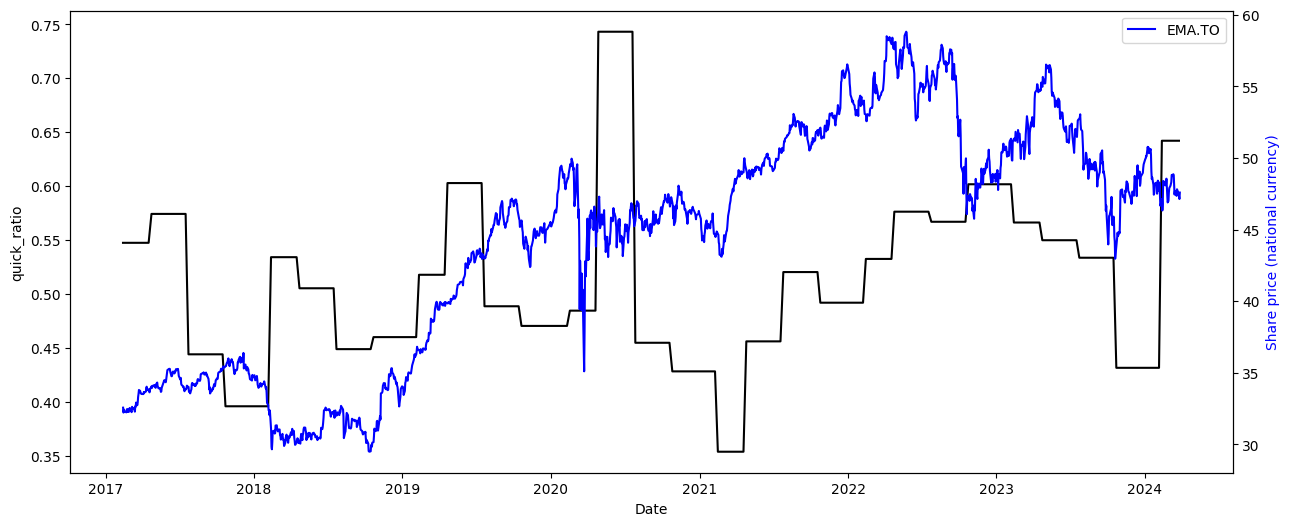

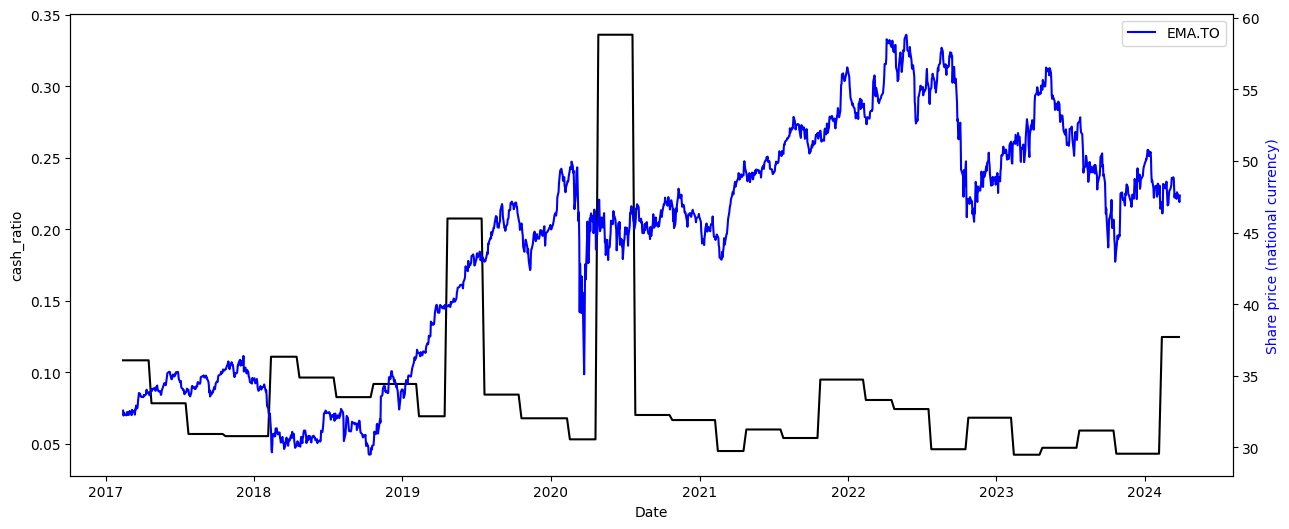

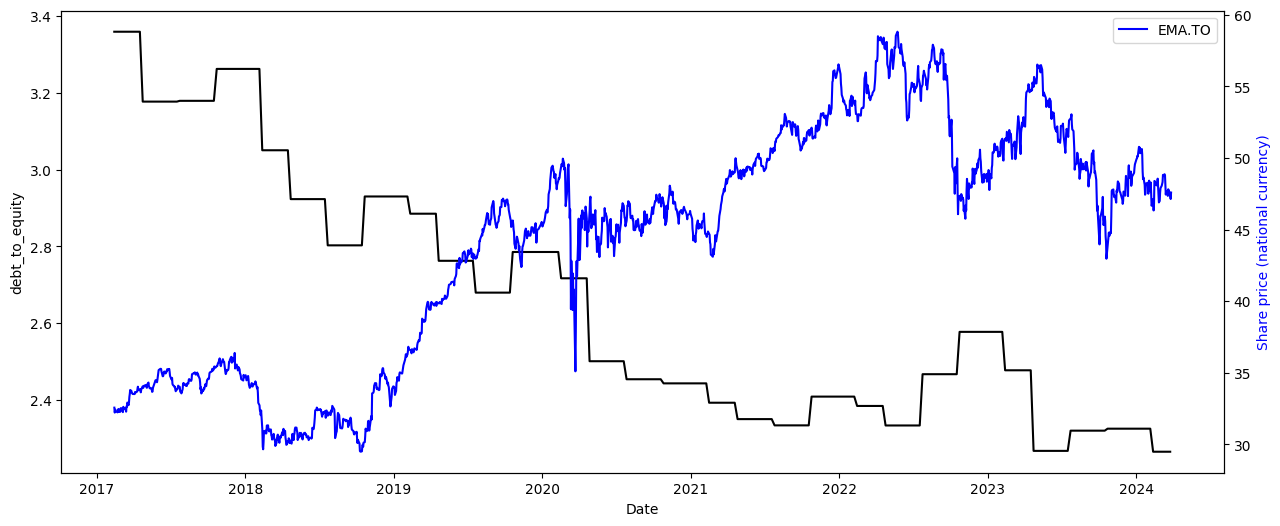

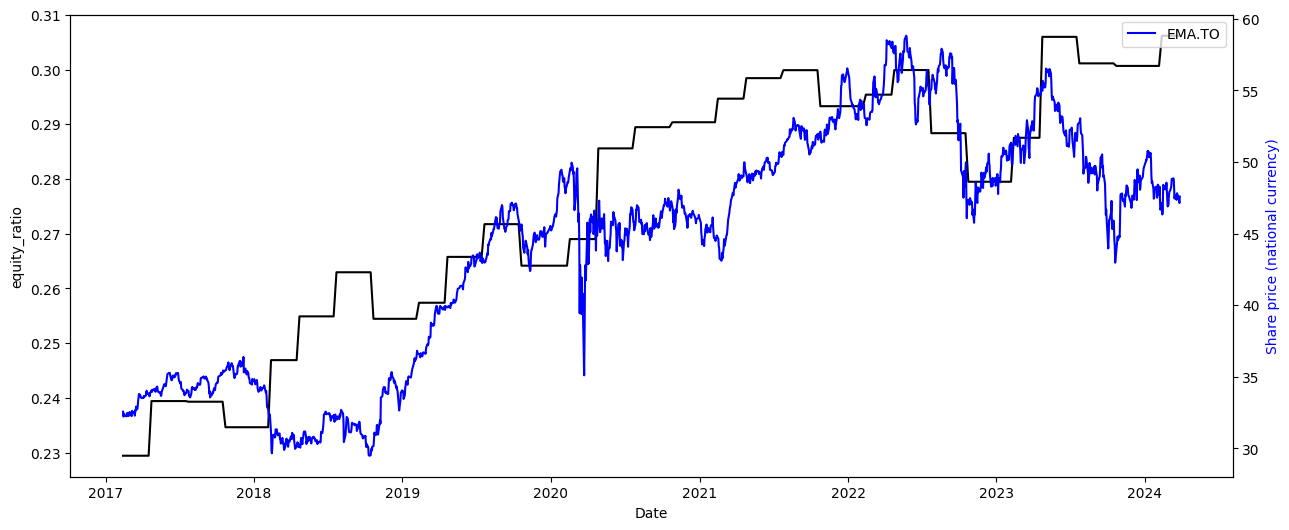

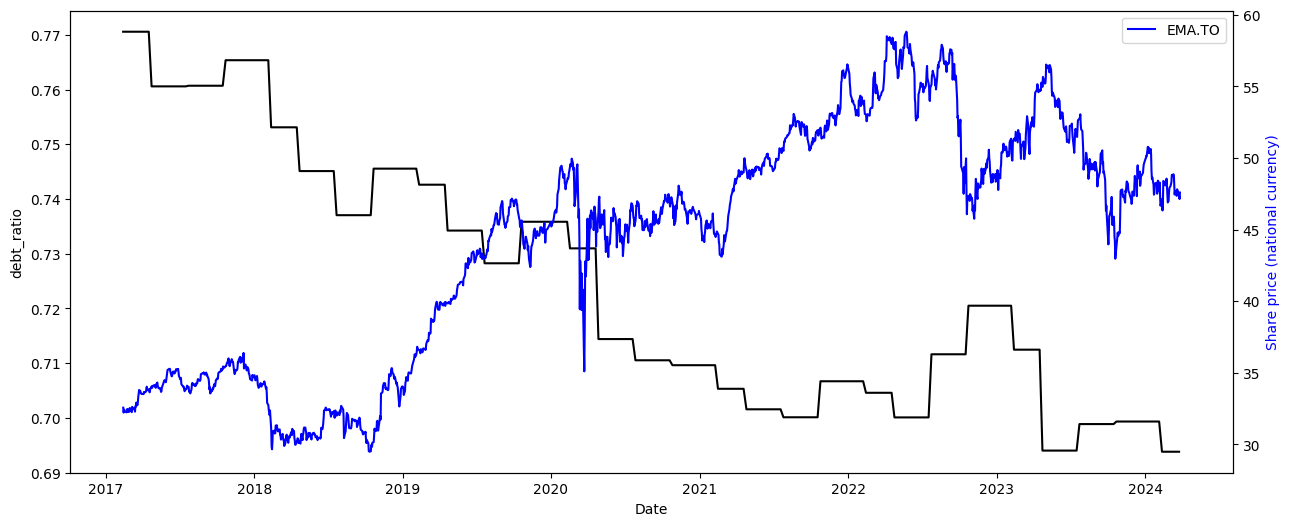

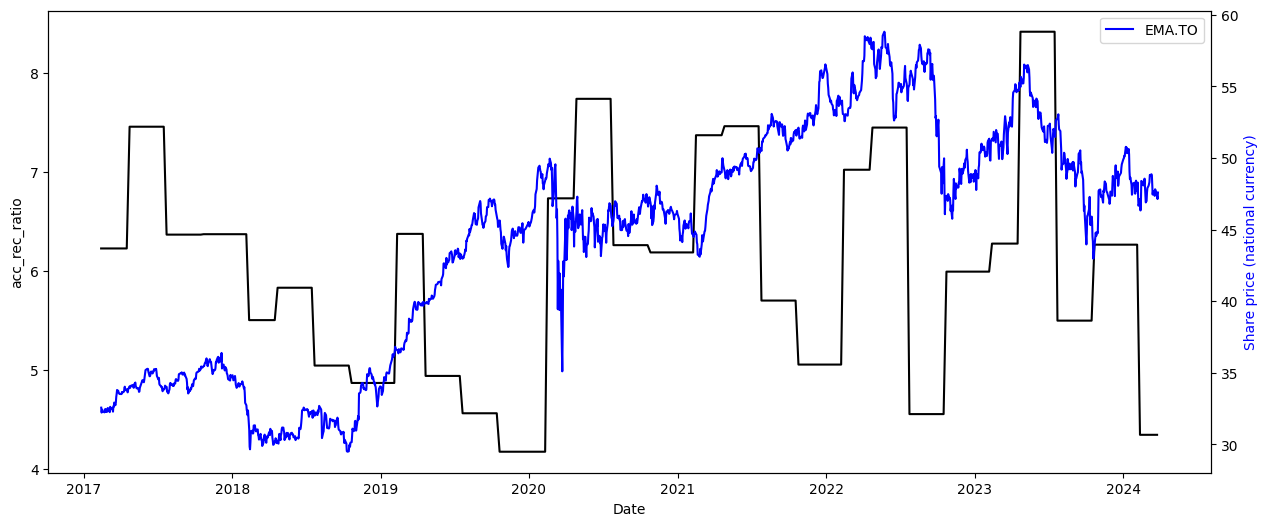

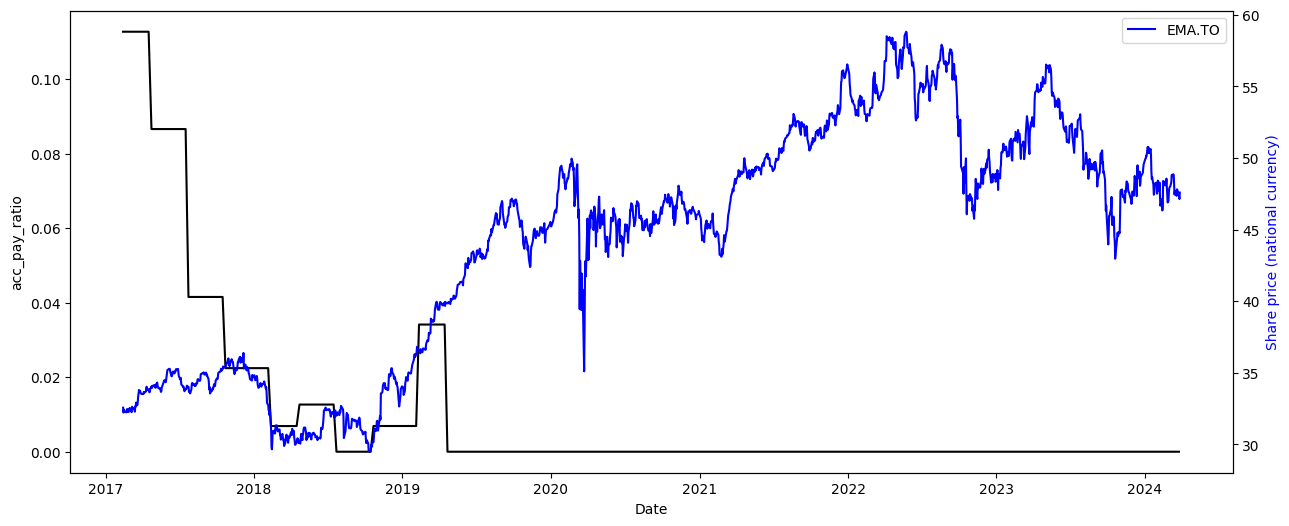

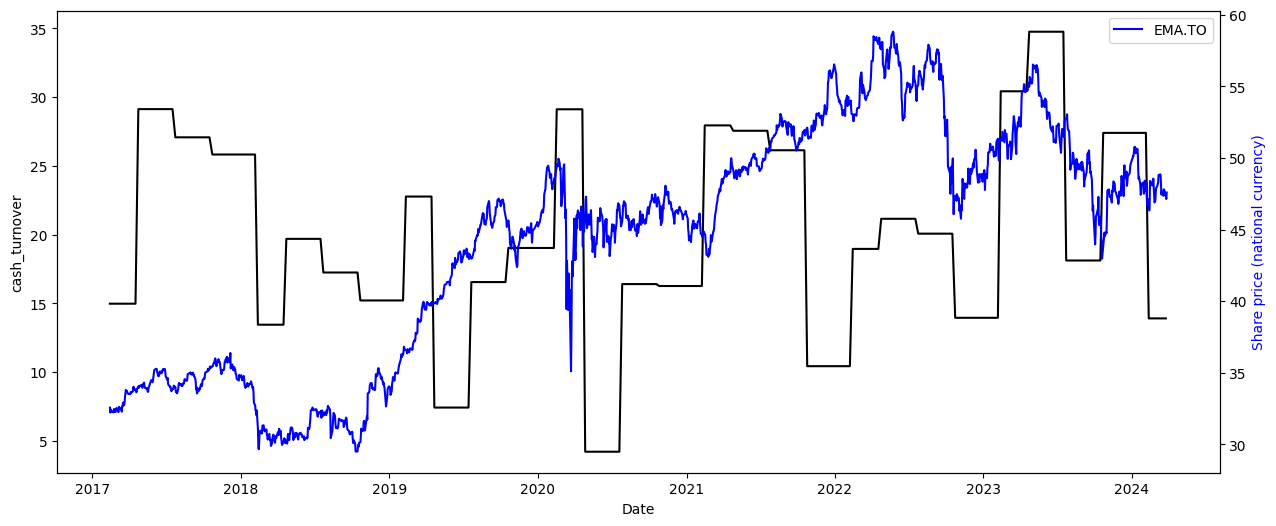

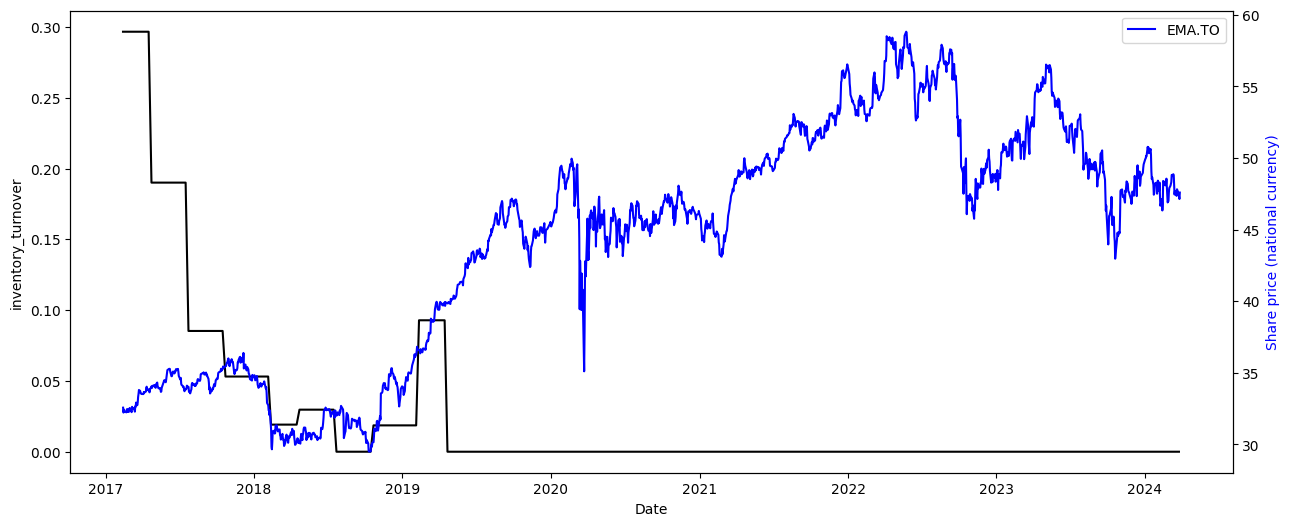

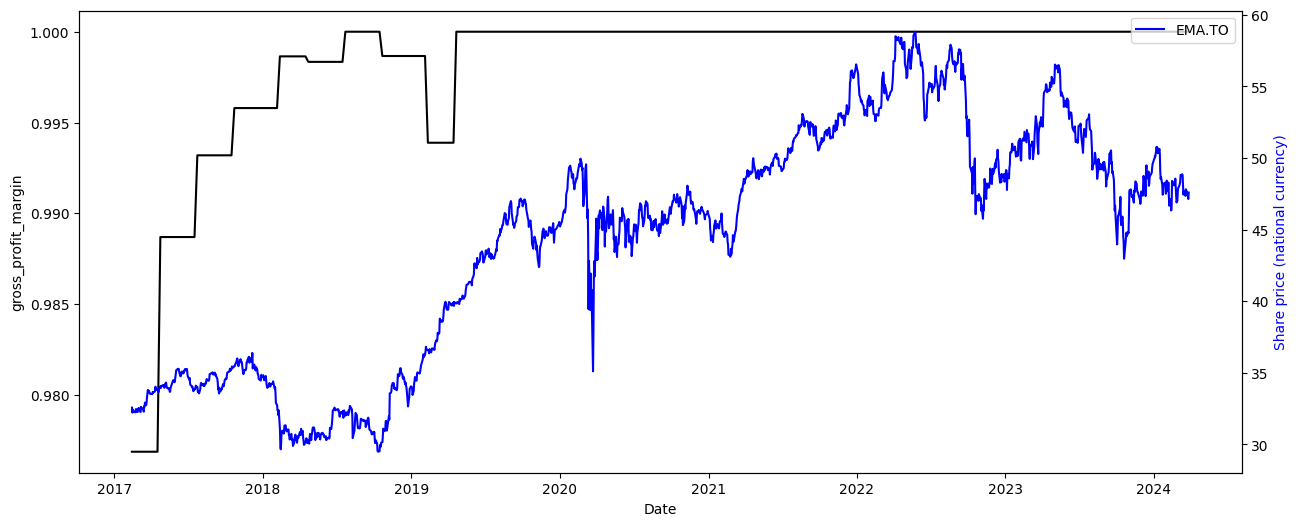

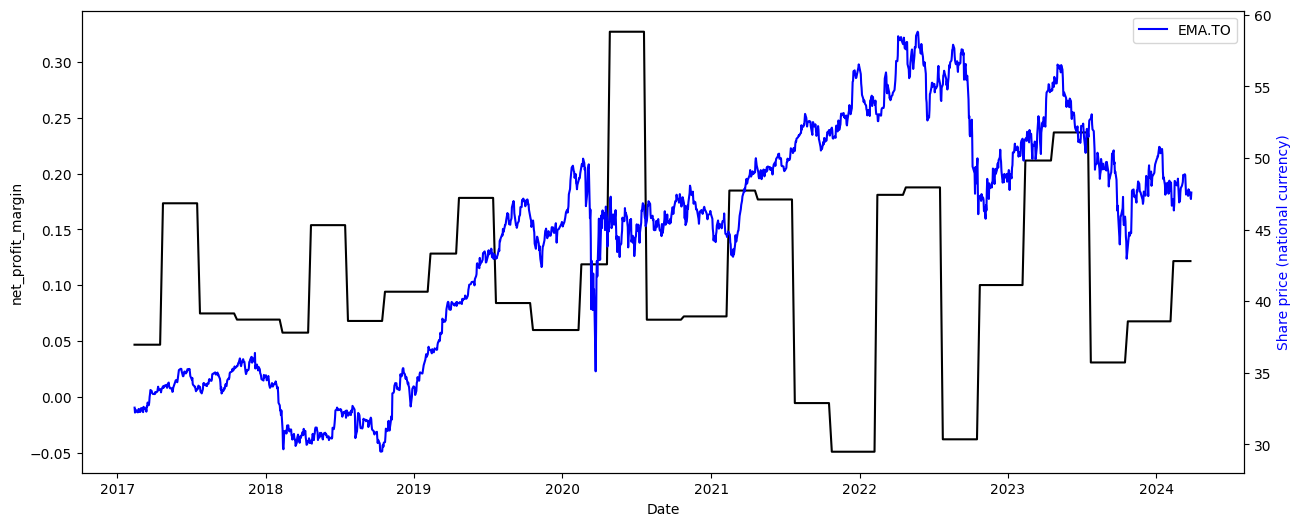

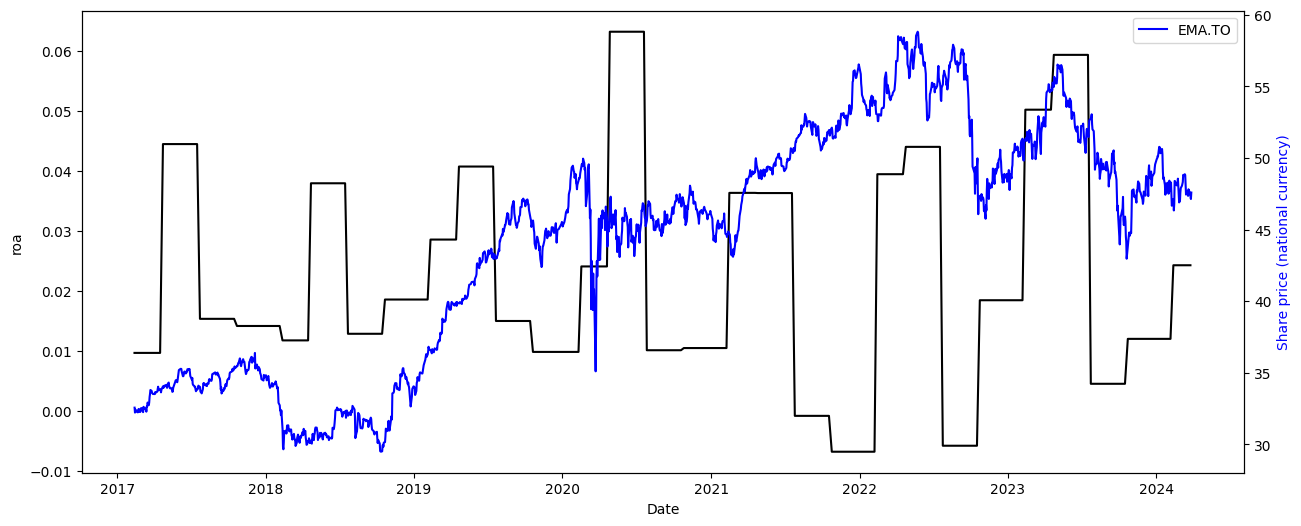

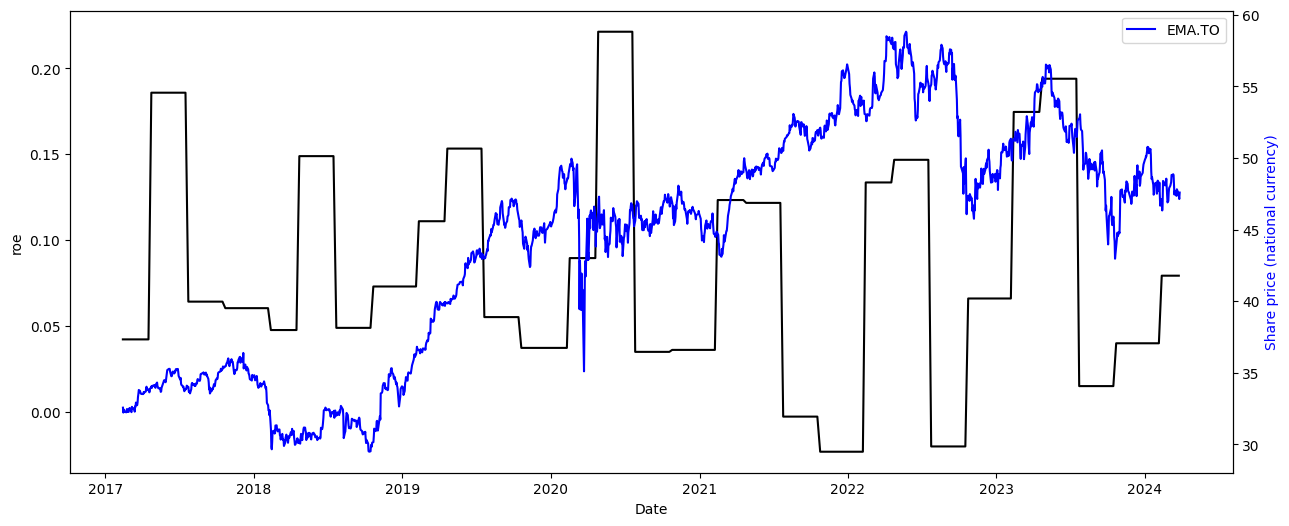

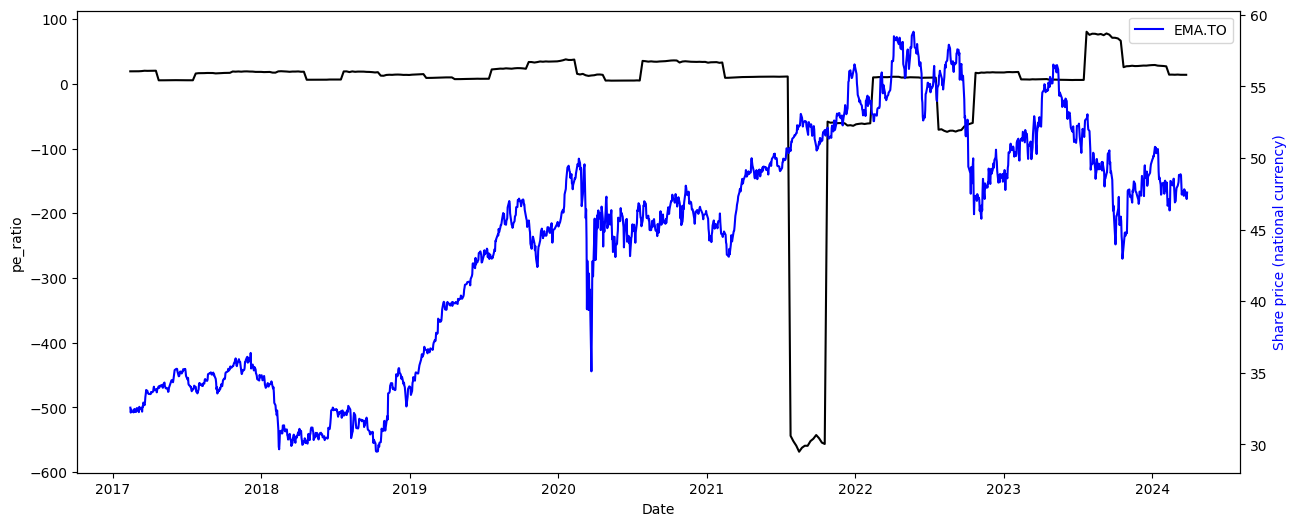

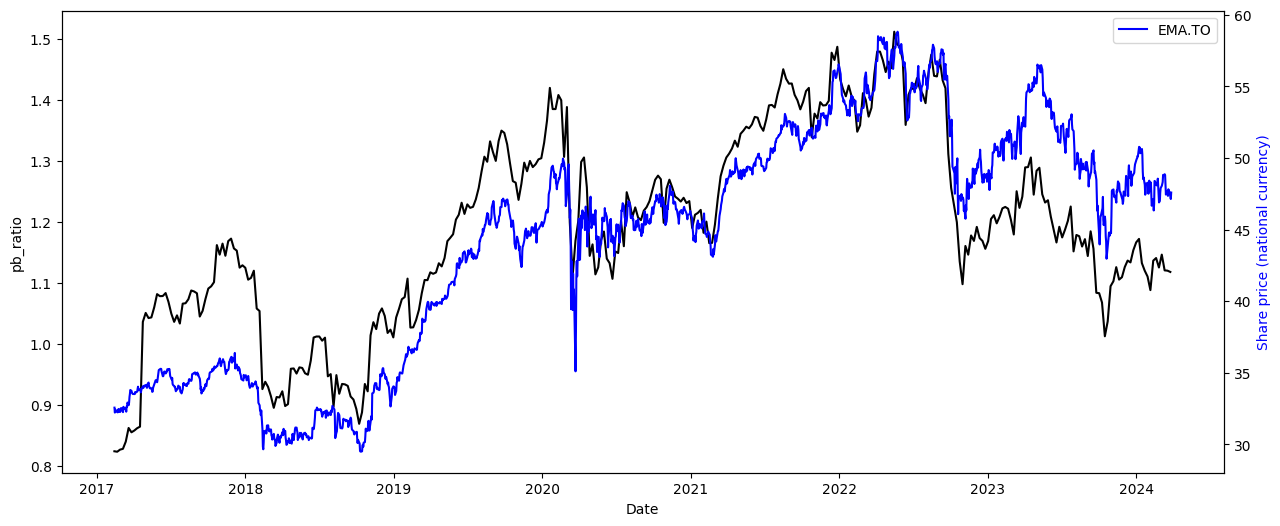

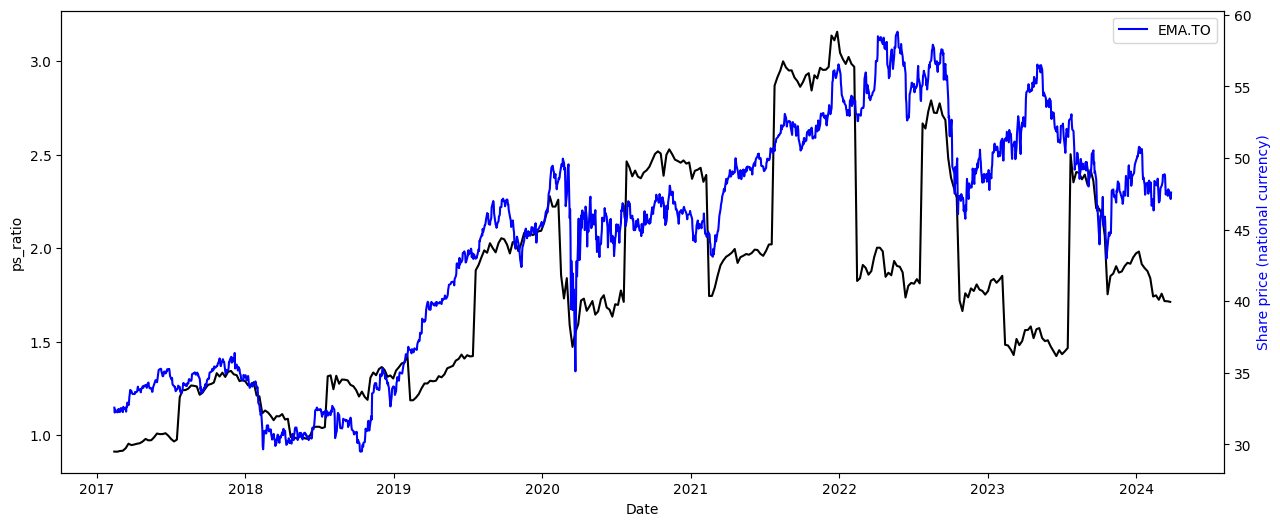

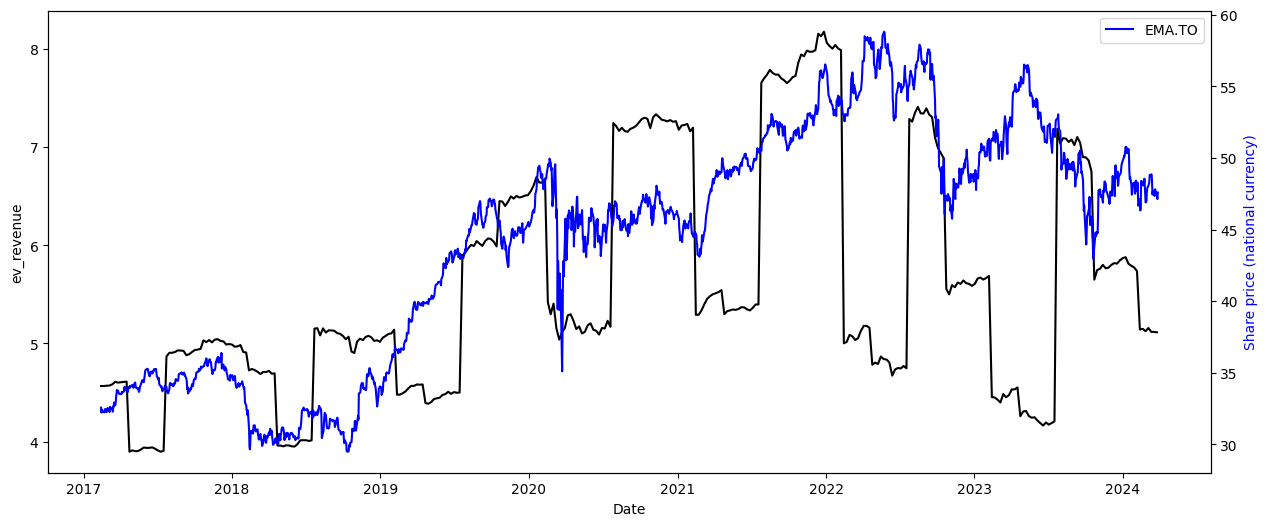

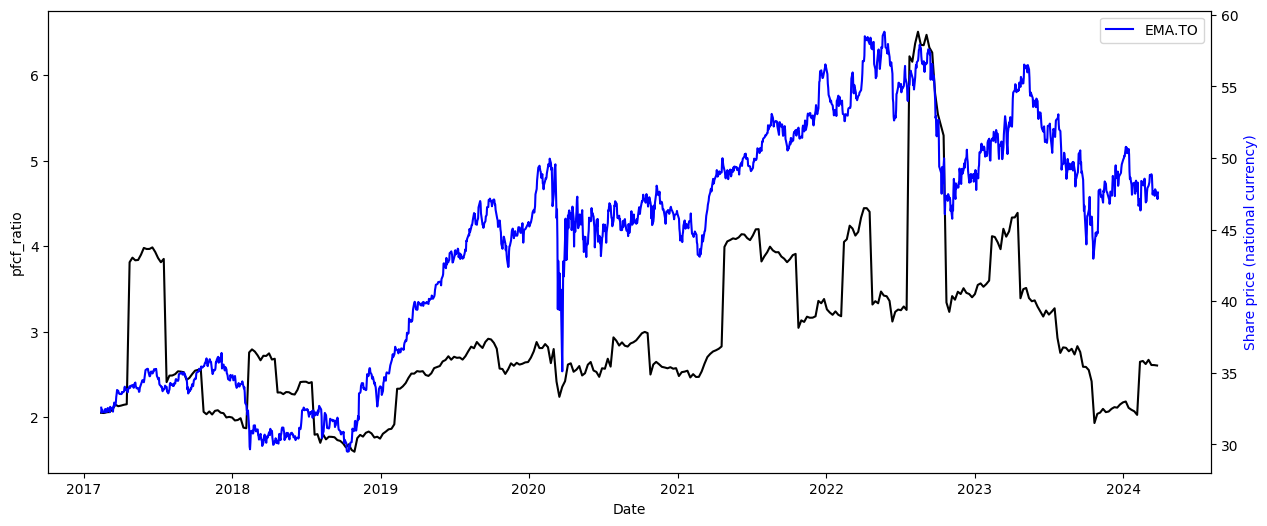

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

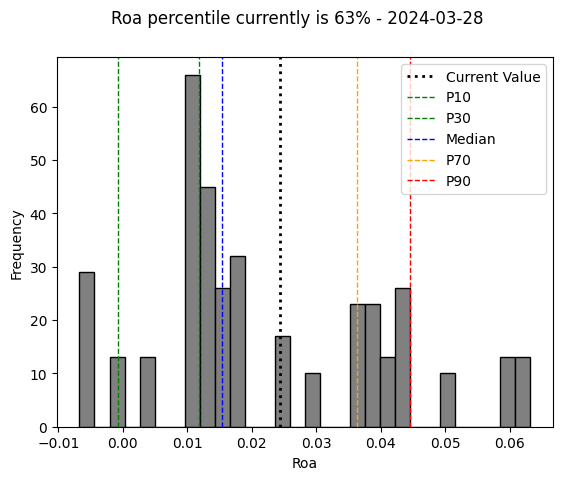

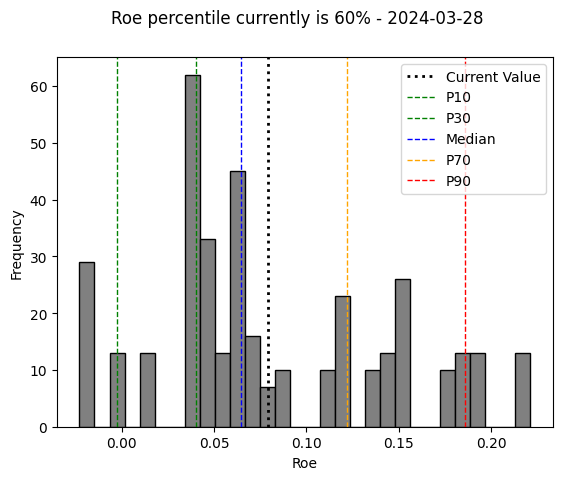

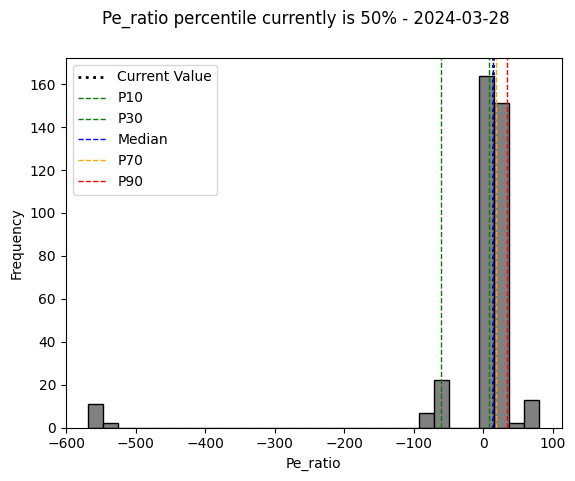

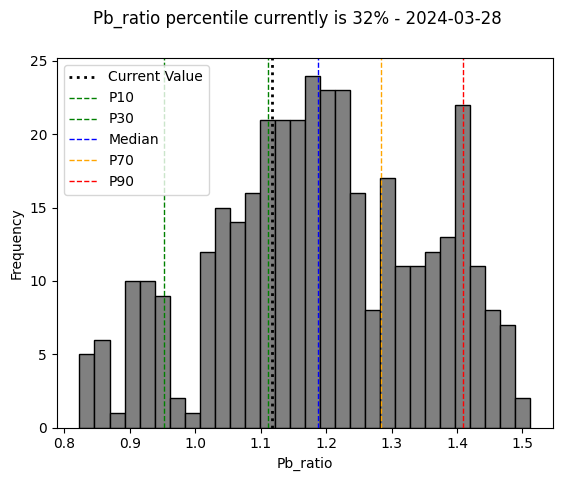

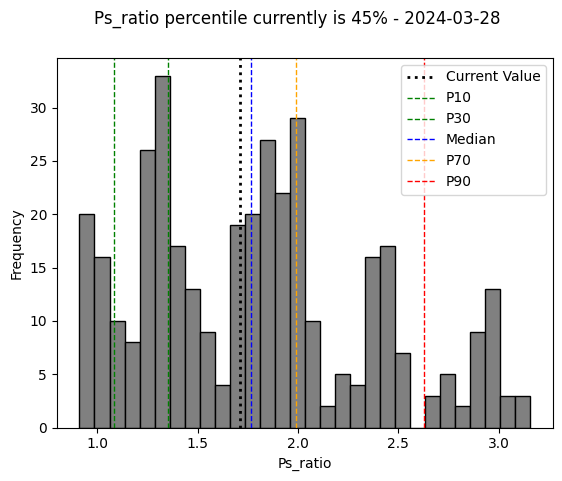

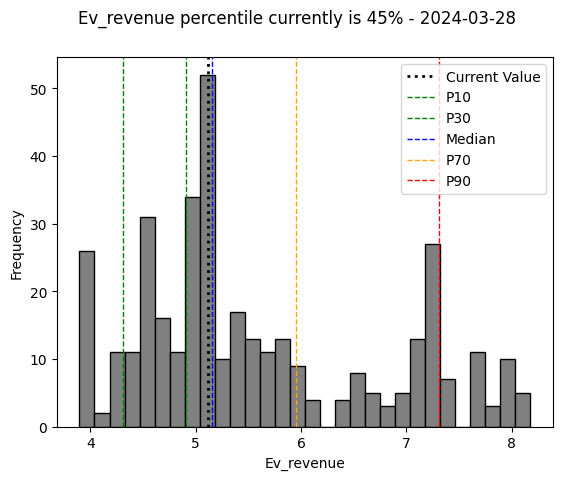

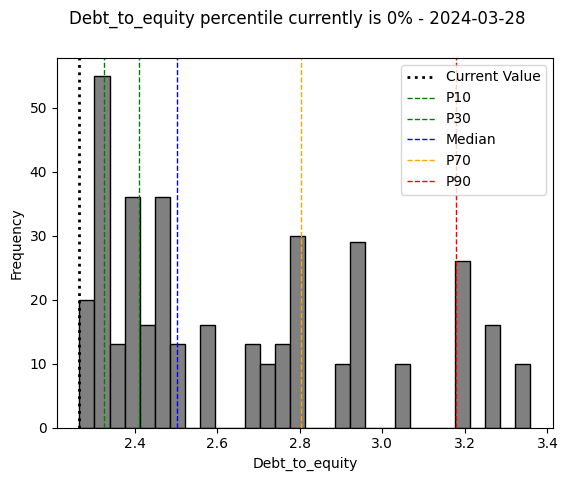

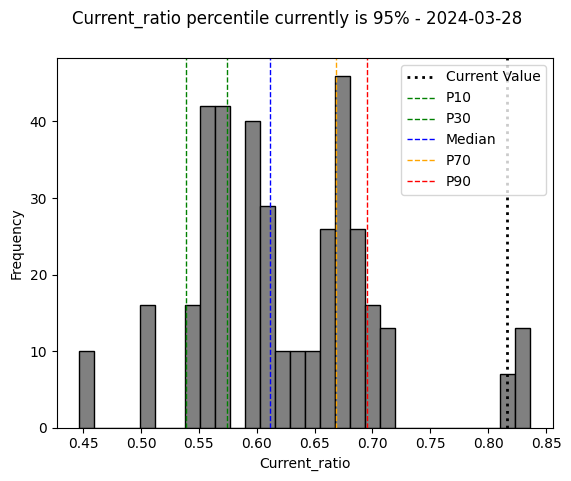

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.991939,0.253647,-0.056914,-0.512322,-0.735329,-0.064263,0.363659
roe,0.991939,1.000000,0.260656,-0.121889,-0.577094,-0.777787,0.039525,0.359466
pe_ratio,0.253647,0.260656,1.000000,-0.335317,-0.426578,-0.373403,0.202096,-0.131761
pb_ratio,-0.056914,-0.121889,-0.335317,1.000000,0.762407,0.533162,-0.634720,-0.003310
ps_ratio,-0.512322,-0.577094,-0.426578,0.762407,1.000000,0.936074,-0.697107,-0.045318
ev_revenue,-0.735329,-0.777787,-0.373403,0.533162,0.936074,1.000000,-0.477294,-0.156214
debt_to_equity,-0.064263,0.039525,0.202096,-0.634720,-0.697107,-0.477294,1.000000,-0.180757
current_ratio,0.363659,0.359466,-0.131761,-0.003310,-0.045318,-0.156214,-0.180757,1.000000


23 timestemos have been found!


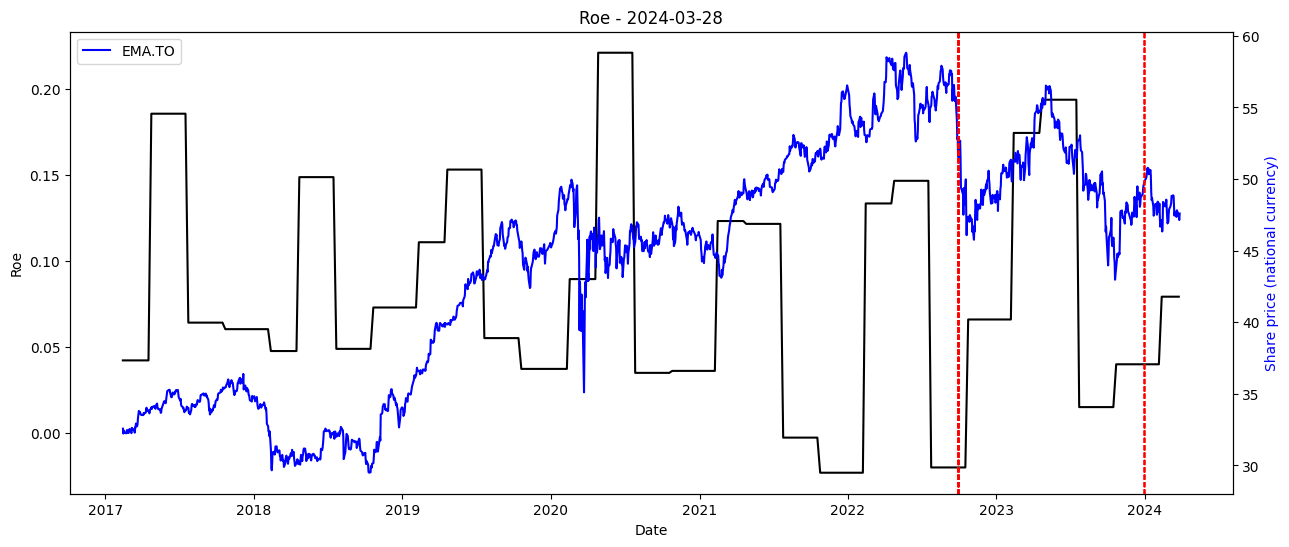

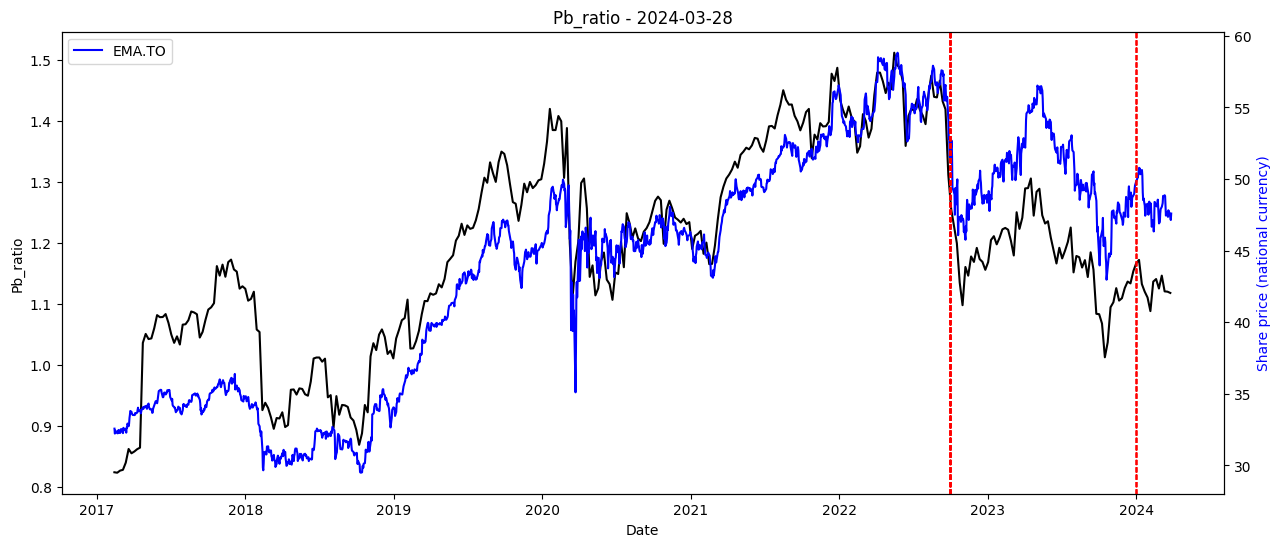

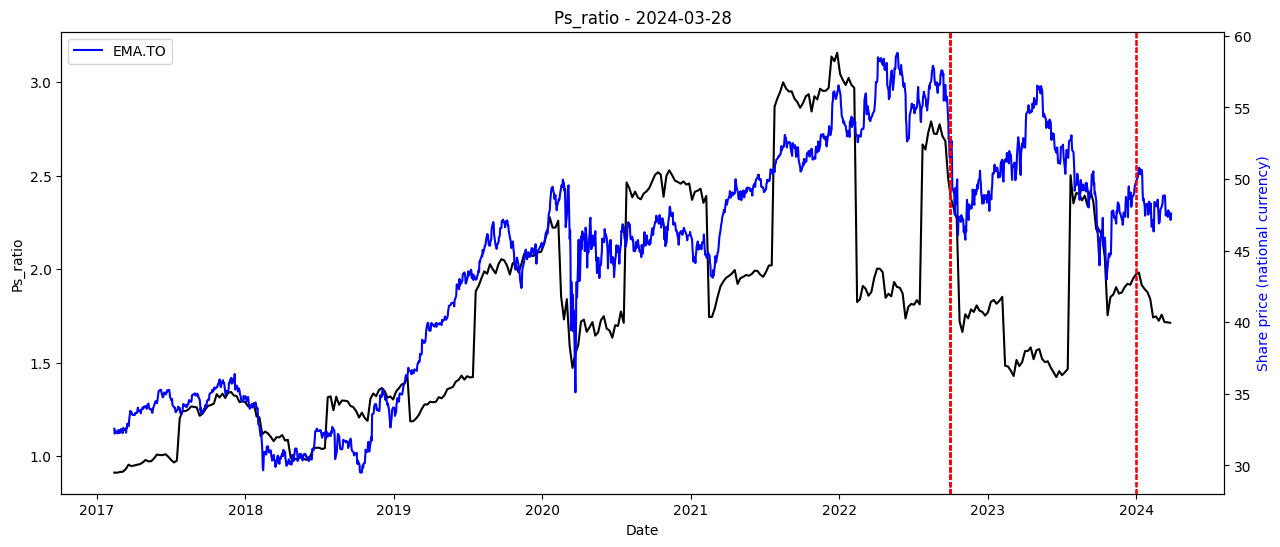

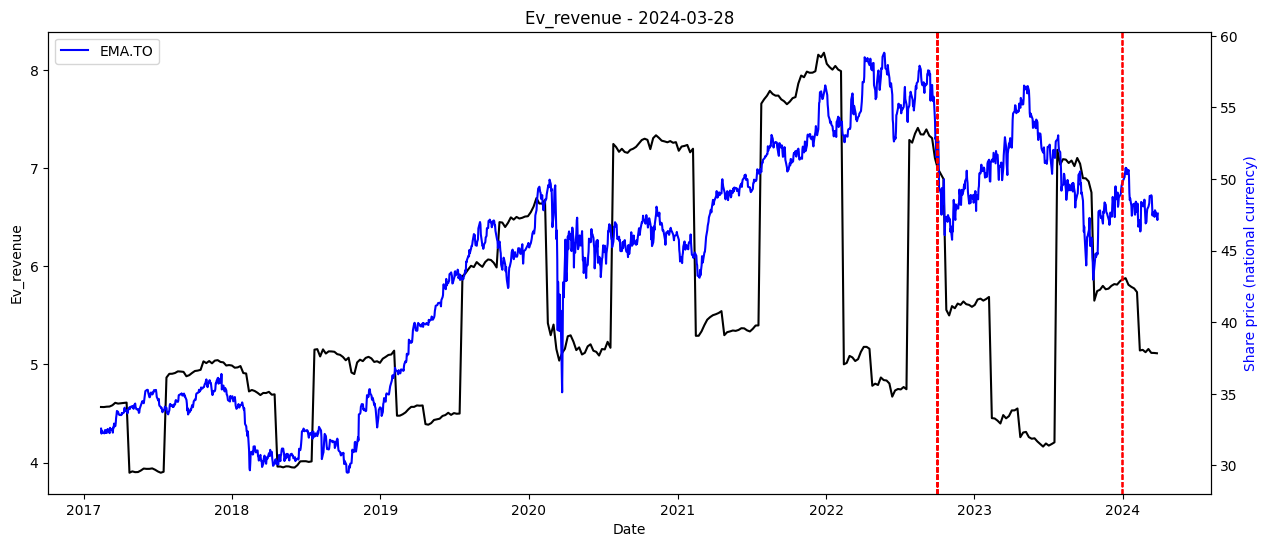

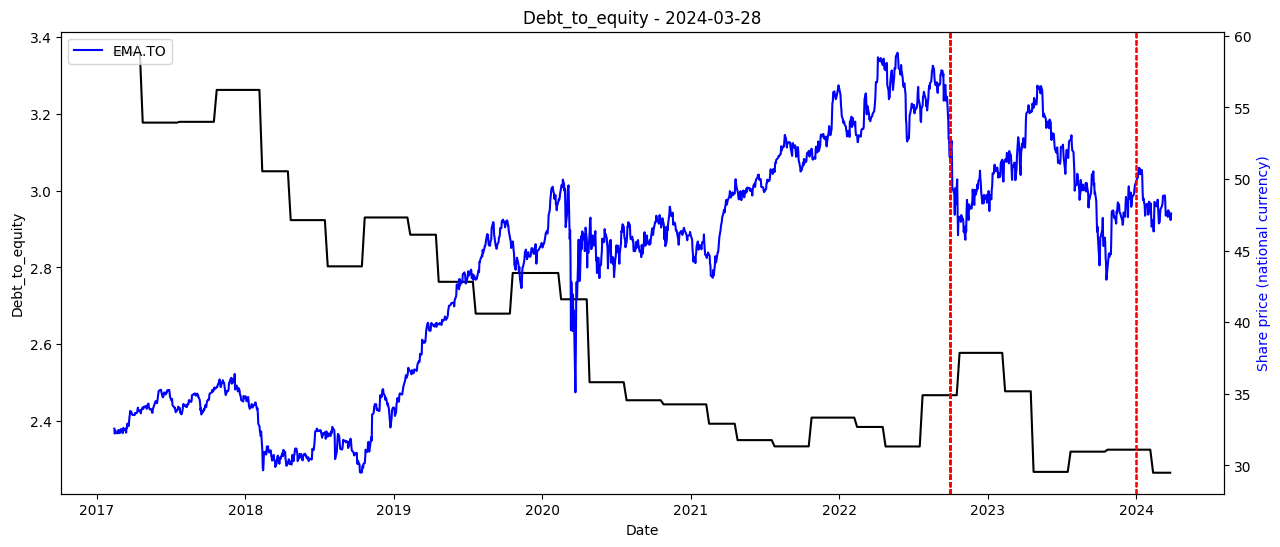

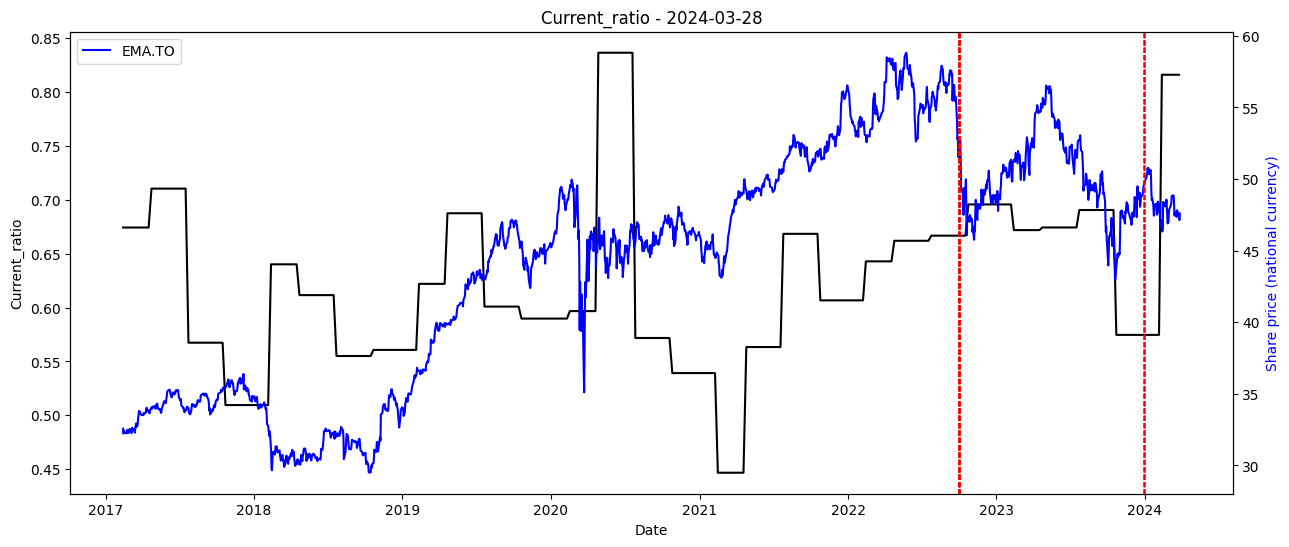

In [21]:
# plot value parameters in time and identify similar events
utils.get_historical_analouges(
    input_df=merged_nat_curr,
    ticker_all_price=ticker_all_price,
    share_name=share_name,
    tolerance=0.2,
    owned_shares=owned_shares
    )